# Introduction

- The training ENV is on window-10 and opencv 2.4.13
- This script is maining test the different ENV on Mac with opencv 3.1.x
- The process-flow are list below step by step.

# Import Modules 

In [1]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json
#from keras.models import load_model


import numpy as np
np.random.seed(1337)  # for reproducibility

import os, sys, progressbar, argparse 
import commentjson as json

from imutils import paths
from skimage.io import imread
import imageio
import cv2

Using Theano backend.


# Data Clean Functions

In [2]:

class Conf:
    def __init__(self, confPath):
        # load and store the configuration and update the object's dictionary
        conf = json.loads(open(confPath).read())
        self.__dict__.update(conf)

    def __getitem__(self, k):
        # return the value associated with the supplied key
        return self.__dict__.get(k, None)
    
    
def auto_resized(img,size):
    '''size = (width,height)'''
    size = tuple(size)
    resize_img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    return resize_img


def TrainFilePath(folderPath, constrain=None, **kargs):
    '''
    (1) Output filepath and calssName
    (2) folderPath 
          --label_1
           -- xxx.jpg
    '''
    assert folderPath[-1]!='/'
    if constrain is None:
        constrain = ('avi', 'mp4','png','jpg') 
    for (rootDir, dirNames, fileNames) in os.walk(folderPath):
        for fileName in fileNames:
            if fileName.split('.')[-1] in constrain:
                yield (os.path.join(rootDir, fileName)) 

#img_channels = 3
def genTrX(filePath, resolution, img_channels=3):
    assert type(resolution) == tuple
    img = auto_resized(imread(filePath),resolution)  #conf['sliding_size']
    if img_channels==1:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif img_channels==3:
        img = img[:,:,:3]
    return img

def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def load_training(folderList):
    TrY = []
    TrX = []
    TrY_template = np.eye(len(folderList))
    for eyeId, folderPath in enumerate(folderList):
        for imgPath in TrainFilePath(folderPath) :
            TrY.append(TrY_template[eyeId])
            TrX.append(genTrX(imgPath, (img_rows,img_cols), img_channels))
    print (len(TrX))
    return TrX, TrY

def reshapeShuffle(TrX, TrY, img_rows, img_cols, img_channels):
    trainX = np.asarray(TrX, dtype = np.uint8)
    trainX = trainX.reshape(trainX.shape[0], img_channels, img_rows, img_cols)
    trainX = trainX.astype('float32')
    trainY = np.asarray(TrY, dtype = np.float32)
    # shuffle
    trainX , trainY = shuffle(trainX,trainY)
    print ('Train_X : ',trainX.shape,'Train_Y' ,trainY.shape)
    return trainX , trainY

# Setting and pre-process the data in consistence

In [3]:
if os.name=='nt':
    foler_list = ['D:\\2D_DataSet\\PureScrewDriver', 'D:\\2D_DataSet\\Rhand_v2']
else:
    foler_list = ['/Users/kentchiu/MIT_Vedio/2D_DataSet/PureScrewDriver', '/Users/kentchiu/MIT_Vedio/2D_DataSet/Rhand_v2']

img_rows = 30
img_cols = 30
img_channels = 1
nb_classes = len(foler_list)

batch_size = 1

# EPOCH SENEITIVE ...
nb_epoch = 25

# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

##############
# Clean Data # 
##############
#model = simpleCNN(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols, img_channels)
#model = simpleCNN_3(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols, img_channels)
TrX, TrY = load_training(foler_list)
trainX , trainY = reshapeShuffle(TrX, TrY, img_rows, img_cols, img_channels=img_channels)

151
('Train_X : ', (151, 1, 30, 30), 'Train_Y', (151, 2))


# Not training mode, use simple train_test_split

In [4]:
Tr_X, Te_X, Tr_Y, Te_Y = train_test_split(trainX, trainY, test_size=0.4, random_state=0)
print ("Training and testing split was successful.")

Training and testing split was successful.


# Loading Model with same setting 

In [5]:

json_file = open('../hub/model/model.json0907_2', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# This should be the same as training 
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
loaded_model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
print ('Successful loading Model')

loaded_model.load_weights('../hub/model/0907_2.h5')
print ('Successful loading Model Weight')

Successful loading Model
Successful loading Model Weight


# Model Evaluations 

In [6]:
score = loaded_model.evaluate(Te_X, Te_Y, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print(loaded_model.summary())

('Test score:', 0.00076956944501974057)
('Test accuracy:', 1.0)
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_15 (Convolution2D)   (None, 32, 28, 28)  320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_32 (Activation)         (None, 32, 28, 28)  0           convolution2d_15[0][0]           
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D)   (None, 32, 26, 26)  9248        activation_32[0][0]              
____________________________________________________________________________________________________
activation_33 (Activation)         (None, 32, 26, 26)  0           convolution2d_16[0][0]           
___________________________

# Further Visualizations

[[  9.99937892e-01   6.20992141e-05]]
1/1 [==============================] - 0s
(array([0]), '--><--', 0)


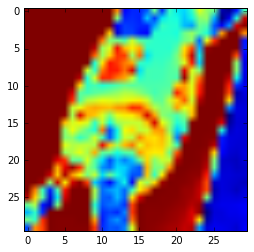

In [7]:

from ipywidgets import interact, interactive, fixed
from ipywidgets import widgets

def f(x):
    
    #plt.imshow(Tr_X[x].reshape(img_rows,img_rows,3)) # color
    plt.imshow(TrX[x].reshape(img_rows,img_rows)) # gray
    print (loaded_model.predict(TrX[x].reshape(1,img_channels,img_rows,img_rows)) )
    print (loaded_model.predict_classes(TrX[x].reshape(1,img_channels,img_rows,img_rows)) ,'--><--', np.argmax(TrY[x]) )

interact(f,x = 20)

# Finding
This result is mainly contribute by different OpenCV-version, so there are slightly different in process the raw image data, this, however, cause a problem as it like before in Recognition problems